Что хотим от модели? Ранжирование объектов для пользователя

Как будет использоваться модель? Рекомендации будут считаться раз в какой-то период

Подходы для разбиения данных на
train/test:


---


● Случайное

● В хронологическом порядке

● По временным периодам

Случайное разбиение


---


● Leave one out (Для test оставляем одно случайное взаимодействие)

● Leave P out (Для test оставляем P случайных взаимодействий)

Хронологическое разбиение - оставляем в test только последние взаимодействия по
пользователям или объектам


---


● Last one out

● Last P out

Разбиение по времени - оставляем в test только конкретный временной промежуток,
например 1 день или 1 неделя.

Я выбрал именно разбиение по времени, по тому что



1.   в электронной коммерции предпочтения пользователей могут меняться со временем.
2.   имитирует ситуацию, когда модель используется в реальном времени для предсказания рекомендаций на основе новых данных
3.    при использовании Time-Based Validation можно избежать утечки информации из будущего в прошлое, что может привести к завышенной оценке качества модели.



При генерации надо учитывать также cold start и warm start сценарии:


---


● Cold start - это пользователи и объекты из test, для которых не известны
взаимодействия

● Warm start - это пользователи и объекты из test, которых не было в train, но для которых на момент построения рекомендаций известны взаимодействия

Схема валидации будет выглядить таким образом, я выбрал 2-уровневую модель.

Для начал стоит разделить данные на глобальный test и train, на train'е будем обучать модели, на test'е проверять.

Выделенный train, делим на 2 части. На одной части обучаем модель первого этапа, на второй предсказываем кандидатов, на этой же части обучаем и проверяем модель 2-го этапа.

Итого, мы обучили 2 модели и теперь можем проверить их качество на глобальном test'е.




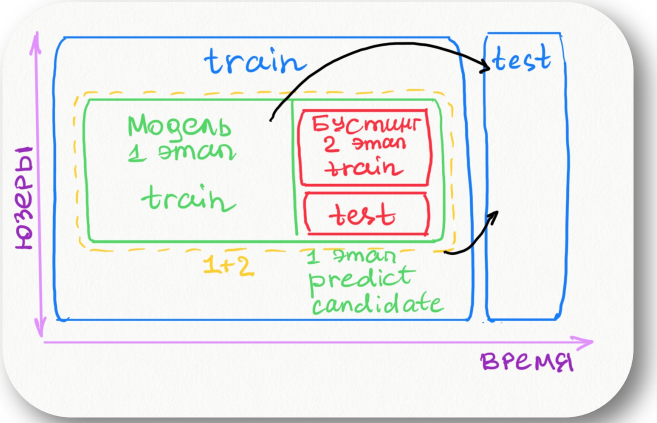

Бустинг будем делить по пользователям:


---


1)Для негативных взаимодействий нет даты

2)Проверяем робастность бустинга относительно новых (холодных) пользователей

# Метрики

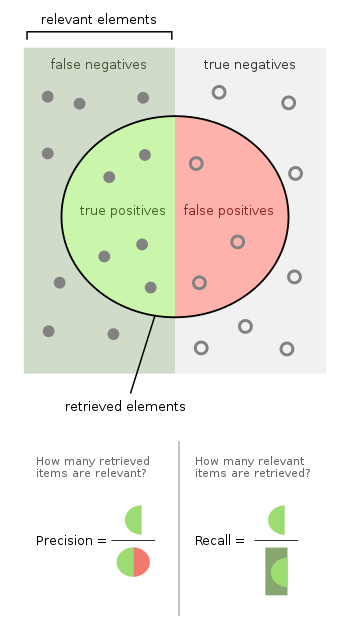

### **Precision (точность)** - это доля релевантных рекомендаций среди всех рекомендаций, предложенных моделью. Precision показывает, насколько точными оказались рекомендации модели. Формула для вычисления Precision: Precision = (Количество релевантных рекомендаций) / (Количество всех рекомендаций).
### **Recall (полнота)** - это доля релевантных рекомендаций, найденных моделью, среди всех релевантных элементов в наборе данных. Recall показывает, насколько хорошо модель обнаруживает все релевантные элементы. Формула для вычисления Recall: Recall = (Количество релевантных рекомендаций) / (Количество всех релевантных элементов).

### **MAP (Mean Average Precision)** - среднее средних точностей. Эта метрика измеряет среднюю точность по всем запросам в наборе данных. Для каждого запроса, мы считаем точность на каждой позиции, где был найден релевантный результат, а затем усредняем эти точности по всем запросам.

### **average precision at K (ap@K)** равна сумме p@k по индексам k от 1 до K только для релевантных элементов, деленому на K:

## $$
 a p @ K=\frac{1}{K} \sum_k^K r^{\text {true }}\left(\pi^{-1}(k)\right) \cdot p @ k
$$

### Идея **map@K** заключается в том, чтобы посчитать ap@K для каждого объекта и усреднить

## \begin{equation} \operatorname{map} @ K=\frac{1}{N} \sum_{j=1}^N a p @ K_j \end{equation}


### **MRR (Mean Reciprocal Rank)** - средний обратный ранг. Эта метрика измеряет среднюю обратную позицию первого релевантного результата. Для каждого запроса, мы находим позицию первого релевантного результата и берем обратное значение этой позиции. Затем усредняем эти обратные значения по всем запросам.

## \begin{equation} R R @ K=\frac{1}{\min \left\{k \in[1 \ldots K]: r^{\text {true }}\left(\pi^{-1}(k)\right)=1\right\}} \end{equation}
## \begin{equation} M R R @ K=\frac{1}{N} \sum_{j=1}^N R R @ K_j \end{equation}

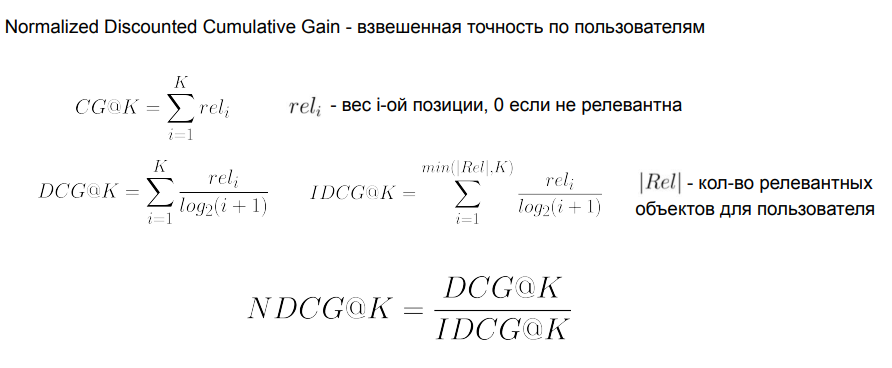

## Для моделей первого этапа мы стараемсся максимизировать **Recall**, потому что наша задача отобрать как можно большее количество потенциальных товаров

## Для модели второго этапа мы будем максимизировать метрику ROC AUC. Потому что это вероятность того, что модель ранжирует случайным образом выбранный положительный экземпляр выше случайным образом выбранного отрицательного экземпляра.

## Общую метрику будем смотреть на MAP, т.к. MAP учитывает не только то, какие элементы релевантны, но и их порядок в ранжированном списке и его легко интерпретировать. Значение 1 означает, что модель всегда ранжирует наиболее релевантные элементы первыми, а значение 0 означает, что модель вообще не ранжирует релевантные элементы.

# Перейдем к реализации решения

# 5 этап

# Сразу хочется сказать что в прошлом решение изначально я не использовал эмбединги от ALS, затем добавил и получил AUC_ROC 0.74, изначально был 0.70. Также метрика Map выросла. Поэтому качество на прошлом решении я уже чуть повысил относительно изначального

# Подбор гиперпараметров занимал очень много времени, поэтому пока я смог только слабо улучшить подбор кандидатов от LightFm, для этого я разделил нашу последнюю неделю (которая была изначально test) на test_val и test_test, тем самым подбор гиперпараметров проводился на test_val (делал я это в другом ноутбуке). Разделил я как примерно 2 дня на val и 5 дней на test

In [ ]:
date_threshold = test['order_ts'].quantile(q=0.3, interpolation='nearest')
date_threshold # '2023-03-27 00:40:54.000000'

In [ ]:
test_val = test[(test['order_ts'] < date_threshold)]
test_test = test[(test['order_ts'] >= date_threshold)]

print(f"test_val: {test_val.shape}") # (411443, 3)
print(f"test_test: {test_test.shape}") # (960035, 3)

In [ ]:
lfm_model = LightFM(
    no_components=64,
    learning_rate=0.1,
    loss='warp',
    max_sampled=5,
    random_state=42
)

num_epochs = 20 # Recall@30  0.175936 на test_val

In [ ]:
lfm_model = LightFM(
    no_components=128,
    learning_rate=0.05,
    loss='warp',
    max_sampled=5,
    random_state=42
)

num_epochs = 20 # Recall@30 0.176684 на test_val

# Итоговую метрику буду считать на test_test

# Пока по 5-ому этапу это все

In [1]:
pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 23.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [3]:
data_test = pd.read_csv("/kaggle/input/wb-school/wb_school_task_1.csv")

In [4]:
data_test

,user_id,item_id,order_ts
0,550614,264,2023-01-01 00:28:09.000000
1,571051,580,2023-01-01 00:41:47.000000
2,571051,180,2023-01-01 00:41:47.000000
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000
...,...,...,...
21265779,249269,348,2023-03-31 23:55:37.182803
21265780,373951,3835,2023-03-31 23:59:24.148327
21265781,505474,1340,2023-03-31 23:59:24.161567
21265782,1011023,153,2023-03-31 23:59:38.371329


## В 1-ом этапе мы провдили EDA и я обнаружил некоторую часть выбросов, избавлюсь от аномальных пользоваталей

## Удалим тех пользователей у которых огромное количесвто заказов одного и того же товара в один момент


In [5]:
max_orders = data_test.groupby(['user_id', 'item_id', 'order_ts']).size().reset_index(name='order_count')
max_orders = max_orders[max_orders['order_count'] > 1].sort_values(by='order_count', ascending=False)
max_orders.head()

,user_id,item_id,order_ts,order_count
11432991,627214,2915,2023-01-20 20:38:50.832636,96
15977095,877108,2915,2023-01-16 18:53:16.000000,78
18578587,1020254,390,2023-02-14 14:14:30.830355,73
17070670,937458,2915,2023-02-24 23:49:47.894690,73
18973605,1041406,2547,2023-03-01 19:18:02.745495,72


In [6]:

user_orders = max_orders.groupby('user_id').size().reset_index(name='order_count')

Q1 = user_orders['order_count'].quantile(0.25)
Q3 = user_orders['order_count'].quantile(0.75)

# Вычисление межквартильного диапазона (IQR)
IQR = Q3 - Q1

# Определение границ выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Нижняя граница выбросов:", lower_bound)
print("Верхняя граница выбросов:", upper_bound)

# Идентификация аномальных пользователей
anomalies_moment = user_orders[(user_orders['order_count'] < lower_bound) | (user_orders['order_count'] > upper_bound)]

print("Аномальные пользователи с аномальным количеством заказов:")
print(anomalies_moment)

Нижняя граница выбросов: -3.5
Верхняя граница выбросов: 8.5
Аномальные пользователи с аномальным количеством заказов:
        user_id  order_count
8            25           20
9            26           12
12           37            9
16           53           19
28           74            9
...         ...          ...
368997  1057085           16
369006  1057108           11
369013  1057124           18
369038  1057192           18
369054  1057234            9

[32923 rows x 2 columns]


In [7]:
# Объединяем data_test с аномалиями, указывая откуда взялись строки
merged = data_test.merge(anomalies_moment, on='user_id', how='left', indicator=True)

# Фильтруем только те строки, которые не являются аномалиями
filtered_data_test = merged[merged['_merge'] == 'left_only']

# Удаляем столбец _merge, который больше не нужен
data_test = filtered_data_test.drop(columns=['_merge'])

In [8]:
data_test = data_test.drop('order_count', axis=1)

In [9]:
data_test

,user_id,item_id,order_ts
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000
5,430392,2652,2023-01-01 01:10:30.000000
6,124741,437,2023-01-01 01:15:03.000000
7,870268,165,2023-01-01 01:34:35.000000
...,...,...,...
21265777,674733,133,2023-03-31 23:36:40.101921
21265778,456675,5507,2023-03-31 23:48:07.498359
21265779,249269,348,2023-03-31 23:55:37.182803
21265780,373951,3835,2023-03-31 23:59:24.148327


## Зафиксировал пока 18037581 заказов, может потом еще почищу данные

In [9]:
print(f"Уникальных юзеров: {data_test['user_id'].nunique():_}")
print(f"Уникальных айтемов: {data_test['item_id'].nunique():_}")

Уникальных юзеров: 1_024_342
Уникальных айтемов: 6_526


In [10]:
max_date = pd.to_datetime(data_test['order_ts'].max())
min_date = pd.to_datetime(data_test['order_ts'].min())
min_date, max_date

(Timestamp('2023-01-01 00:00:05'), Timestamp('2023-03-31 23:59:59.947831'))

## На test оставим пока последнюю неделю

In [11]:
train = data_test[(pd.to_datetime(data_test['order_ts']) < max_date - pd.Timedelta(days=7))]
test = data_test[(pd.to_datetime(data_test['order_ts']) >= max_date - pd.Timedelta(days=7))]




print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (16569405, 3)
test: (1468176, 3)


In [13]:
test

,user_id,item_id,order_ts
10867307,804060,5734,2023-03-25 00:01:25.435029
10867308,100010,283,2023-03-25 00:01:29.907382
10867309,105046,721,2023-03-25 00:05:44.271706
10867310,168105,950,2023-03-25 00:07:58.581428
10867311,943459,106,2023-03-25 00:11:18.475399
...,...,...,...
21265777,674733,133,2023-03-31 23:36:40.101921
21265778,456675,5507,2023-03-31 23:48:07.498359
21265779,249269,348,2023-03-31 23:55:37.182803
21265780,373951,3835,2023-03-31 23:59:24.148327


## Получили общую трейновую и тестовую выборку.

## Теперь разделим наш train еще на 2 части.

## **train + pred for candidates**

## Разделим данные на cf_train и cf_pred как 70%-30% по квантилю даты просмотра

## На **cf_pred** будем в дальнейшем обучать бустинг - модель 2 этапа

In [12]:
cf_date_threshold = train['order_ts'].quantile(q=0.7, interpolation='nearest')
cf_date_threshold

'2023-03-02 08:56:57.300818'

In [13]:
cf_train = train[(train['order_ts'] < cf_date_threshold)]
cf_pred = train[(train['order_ts'] >= cf_date_threshold)]

print(f"cf_train: {cf_train.shape}")
print(f"cf_pred: {cf_pred.shape}")

cf_train: (11598574, 3)
cf_pred: (4970831, 3)


## Будем предсказывать кандидатов только на теплых пользователях - у которых есть заказы в обучающей выборке



In [14]:
cf_pred = cf_pred[cf_pred['user_id'].isin(cf_train['user_id'].unique())]
print(f"cf_pred: {cf_pred.shape}")

cf_pred: (4689810, 3)


In [15]:
cf_train.head()

,user_id,item_id,order_ts
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000
5,430392,2652,2023-01-01 01:10:30.000000
6,124741,437,2023-01-01 01:15:03.000000
7,870268,165,2023-01-01 01:34:35.000000


In [16]:
cf_train.shape

(11598574, 3)

### Функция для подсчета метрик

In [36]:
def compute_metrics(df_true, df_pred, top_N, rank_col='rank'):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in [top_N]:
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

# Затем, мы уже обучаем модель первого этапа.

## Топ популярного

In [18]:
recs = pd.DataFrame({'user_id': test['user_id'].unique()})
recs.head()

,user_id
0,804060
1,100010
2,105046
3,168105
4,943459


In [19]:
top_30_items = cf_train['item_id'].value_counts().head(30).index.tolist()
top_30_items

[192,
 390,
 69,
 357,
 133,
 381,
 11,
 212,
 180,
 1571,
 360,
 358,
 363,
 2915,
 4853,
 162,
 168,
 347,
 213,
 105,
 184,
 50,
 82,
 217,
 38,
 185,
 41,
 350,
 593,
 385]

In [20]:
recs['item_id'] = [top_30_items] * len(recs)

In [21]:
recs.sort_values(
    by=['user_id'], ascending=[True]).head(15)

,user_id,item_id
258845,3,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
156615,6,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
397517,7,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
248839,8,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
122162,14,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
407547,15,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
246740,20,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
372124,28,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
268940,29,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."
396409,30,"[192, 390, 69, 357, 133, 381, 11, 212, 180, 15..."


In [22]:
recs = recs.explode(column=['item_id'])

recs['rank'] = recs.groupby('user_id').cumcount() + 1

recs.head(31)

,user_id,item_id,rank
0,804060,192,1
0,804060,390,2
0,804060,69,3
0,804060,357,4
0,804060,133,5
0,804060,381,6
0,804060,11,7
0,804060,212,8
0,804060,180,9
0,804060,1571,10


In [23]:
recs.sort_values(
    by=['user_id'], ascending=[True]).head(5)

,user_id,item_id,rank
258845,3,381,6
258845,3,192,1
258845,3,390,2
258845,3,69,3
258845,3,357,4


### Посчитаем метрики для топ популярного

In [24]:
test_pop = test.copy()

In [25]:
test_pop.head()

,user_id,item_id,order_ts
10867307,804060,5734,2023-03-25 00:01:25.435029
10867308,100010,283,2023-03-25 00:01:29.907382
10867309,105046,721,2023-03-25 00:05:44.271706
10867310,168105,950,2023-03-25 00:07:58.581428
10867311,943459,106,2023-03-25 00:11:18.475399


In [37]:
pop_metrics = compute_metrics(test_pop[['user_id', 'item_id']], recs, top_N=30)

In [38]:
pop_metrics

Precision@30    0.031895
Recall@30       0.258167
MAP@30          0.080841
MRR             0.125489
dtype: float64

## ТОП популярного будет в качестве бейзлайна который мы попытаемся побить.

## LIghtFM

In [39]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=464211 sha256=97bbaebbb01a8a3b551f9ed496bd57198dcbe56261df3b3f2204a43284f84d88
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [40]:
from lightfm.data import Dataset
from lightfm import LightFM

In [41]:
dataset = Dataset()
dataset.fit(cf_train['user_id'].unique(), cf_train['item_id'].unique())
cf_train.head()

,user_id,item_id,order_ts
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000
5,430392,2652,2023-01-01 01:10:30.000000
6,124741,437,2023-01-01 01:15:03.000000
7,870268,165,2023-01-01 01:34:35.000000


In [42]:
from tqdm import tqdm

tqdm.pandas()

interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*cf_train[['user_id', 'item_id']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [43]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 914908
items_mapping amount: 6375


In [44]:
lfm_model = LightFM(
    no_components=64,
    learning_rate=0.1,
    loss='warp',
    max_sampled=5,
    random_state=42
)

In [45]:
from tqdm import tqdm

num_epochs = 20

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )

100%|██████████| 20/20 [06:50<00:00, 20.53s/it]


In [26]:
%%capture
pip install dill

In [46]:
import dill
# save model
with open(f"lfm_model_version1.dill", 'wb') as f:
    dill.dump(lfm_model, f)

## Посчитаем метрики

### Функция, для генерации кандидатов, с возможностью исключить ранеее купленные товары

In [46]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, 
                                 user_features, item_features, N, 
                                 user_mapping, item_inv_mapping, 
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, 
                             item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user]) if user in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [47]:
test_lfm = test[test['user_id'].isin(cf_train['user_id'].unique())]

In [48]:
lfm_prediction = pd.DataFrame({
    'user_id': test_lfm['user_id'].unique()
})

In [49]:
lfm_prediction.shape

(380800, 1)

In [50]:
top_N = 30
known_items = cf_train.groupby('user_id')['item_id'].apply(list).to_dict()
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['item_id'] = lfm_prediction['user_id'].map(mapper)
lfm_prediction = lfm_prediction.explode('item_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1 

In [51]:
lfm_prediction.sample(5)

,user_id,item_id,rank
6959050,889170,133,11
10450681,19290,57,2
8201571,1002334,170,22
10689314,769923,436,15
9732801,383128,367,22


## Взглянем на пример предсказаний

In [75]:
lfm_prediction[lfm_prediction['user_id'] == 592148]

,user_id,item_id,rank
704370,592148,5215,1
704371,592148,185,2
704372,592148,69,3
704373,592148,192,4
704374,592148,38,5
704375,592148,5267,6
704376,592148,191,7
704377,592148,151,8
704378,592148,184,9
704379,592148,180,10


In [77]:
cf_train[cf_train['user_id'] == 592148]

,user_id,item_id,order_ts
447620,592148,107,2023-01-31 01:42:27.116283
658253,592148,107,2023-02-07 17:55:16.439478
1365440,592148,11,2023-02-20 12:51:05.440216
3744547,592148,5217,2023-01-23 01:04:30.416156
5300808,592148,1206,2023-01-23 01:19:40.124526
5345054,592148,5217,2023-01-23 01:04:39.199487
5358760,592148,2230,2023-01-23 01:21:42.529165
5360458,592148,1206,2023-01-23 01:20:04.688664
6853685,592148,250,2023-02-07 11:46:19.789600
7239860,592148,107,2023-01-31 01:38:25.110558


## Посчитаем наконец метрики

In [80]:
pop_metrics = compute_metrics(test_lfm[['user_id', 'item_id']], lfm_prediction, top_N=30)

In [81]:
pop_metrics

Precision@1     0.040284
Recall@1        0.011679
Precision@30    0.021161
Recall@30       0.175936
MAP@30          0.044816
MRR             0.078414
dtype: float64

## ALS

In [28]:
import dill

path = "/kaggle/input/ctbcls/other/ctbcls/2/als_model_version1.dill"

with open(path, 'rb') as f:
       als_model = dill.load(f)

In [29]:
test = test[test['user_id'].isin(cf_train['user_id'].unique())]

In [30]:
cf_train.head()

,user_id,item_id,order_ts
3,47164,5135,2023-01-01 00:53:35.000000
4,219072,2668,2023-01-01 01:02:29.000000
5,430392,2652,2023-01-01 01:10:30.000000
6,124741,437,2023-01-01 01:15:03.000000
7,870268,165,2023-01-01 01:34:35.000000


In [31]:
cf_train.shape

(11598574, 3)

In [32]:
als_train = cf_train.copy()

In [33]:
als_train['rec'] = 1

In [34]:
# items
items_set = set(als_train.item_id)
items_dict = {item: iditem for item, iditem in zip(items_set, range(len(items_set)))}
inv_items_map = {v: k for k, v in items_dict.items()}

print(f'Кол-во предметов: {len(items_set)}')

Кол-во предметов: 6375


In [35]:
# аналогично для users
users_set = set(als_train.user_id)
users_dict = {user: iduser for user, iduser in zip(users_set, range(len(users_set)))}
inv_users_map = {v: k for k, v in users_dict.items()}

print(f'Кол-во пользователей: {len(users_set)}')

Кол-во пользователей: 914908


In [36]:
print(f'Размер будущей матрицы: {len(users_set)} х {len(items_set)}')

Размер будущей матрицы: 914908 х 6375


In [37]:
# значения для подстановки в матрицу
values = als_train.rec.tolist()
print(f'Кол-во записей о покупках: {len(values)}')

Кол-во записей о покупках: 11598574


In [38]:
# строки матрицы - пользователи
users = als_train.user_id.map(users_dict)
users

3            40801
4           189119
5           372050
6           107827
7           752954
             ...  
15324260    543907
15324262    362658
15324263    905601
15324264    168728
15324268    636199
Name: user_id, Length: 11598574, dtype: int64

In [39]:

items = als_train.item_id.map(items_dict)
items

3           4328
4           2208
5           2194
6            288
7             88
            ... 
15324260       7
15324262    1350
15324263      56
15324264      21
15324268     216
Name: item_id, Length: 11598574, dtype: int64

In [93]:
# матрица user_item
user_item = csr_matrix((values, (users, items)), shape=(len(users_set), len(items_set)))
user_item

<914908x6375 sparse matrix of type '<class 'numpy.int64'>'
	with 8350999 stored elements in Compressed Sparse Row format>

In [31]:
als_model = AlternatingLeastSquares(factors=50, 
                                regularization=0.05, 
                                iterations=30,
                                random_state=10,
                                )
als_model.fit(user_item)

  0%|          | 0/30 [00:00<?, ?it/s]

In [34]:
import dill
with open(f"als_model_version1.dill", 'wb') as f:
    dill.dump(als_model, f)

In [40]:
item_embeddings = als_model.item_factors
user_embeddings = als_model.user_factors

In [35]:
recs = pd.DataFrame({'user_id': test['user_id'].unique()})
recs.head()

,user_id
0,804060
1,100010
2,105046
3,168105
4,943459


In [36]:
recs.shape

(380800, 1)

In [37]:
def recommends_als(x, top_N):
    x = users_dict[x]
    rec = pd.Series(als_model.recommend(x, user_item[x], N=top_N)[0]).map(inv_items_map).to_list()

    return rec

In [ ]:
recs['item_id'] = recs.user_id.apply(recommends_als, args=(10,))

In [ ]:
recs.head()

### К сожалению не получилось получить кандидатов от ALS, очень долго все предиктило, добавлю их позже, но от ALS я воспользуюсь эмбедингами

# Генерируем предсказания LightFM как кандидатов для второго этапа

In [96]:
cf_pred = cf_pred[cf_pred['user_id'].isin(cf_train['user_id'].unique())]
print(f"cf_pred: {cf_pred.shape}")

cf_pred: (4689810, 3)


In [97]:
# пустой датафрейм для предсказания
candidates = pd.DataFrame({
    'user_id': cf_pred['user_id'].unique()
})

candidates.head(3)

,user_id
0,976990
1,884883
2,951343


In [98]:


# кол-во кандидатов 
top_N = 30

# вспомогательные данные 
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=dict(),
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [99]:

candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1 

candidates.head(5)

,user_id,item_id,rank
0,976990,1359,1
0,976990,192,2
0,976990,1291,3
0,976990,3871,4
0,976990,390,5


In [100]:
candidates.shape #19249680

(19249680, 3)

In [101]:
candidates.sample(5)

,user_id,item_id,rank
453879,465753,133,13
590429,960242,1918,29
537073,924738,192,5
569339,48439,82,10
344973,388849,777,24


# Собираем train + target

In [102]:
pos = candidates.merge(cf_pred,
                        on=['user_id', 'item_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(1273467, 5)


,user_id,item_id,rank,order_ts,target
0,884883,390,1,2023-03-02 08:58:12.691537,1
1,884883,390,1,2023-03-03 00:33:54.108791,1
2,884883,50,17,2023-03-08 14:18:34.473011,1
3,380771,381,1,2023-03-02 09:01:35.633970,1
4,380771,381,1,2023-03-19 14:17:21.547372,1


In [103]:
pos.sample(5)

,user_id,item_id,rank,order_ts,target
110667,194629,2915,12,2023-03-24 16:19:02.872021,1
330864,408672,212,15,2023-03-11 13:29:07.985479,1
337853,629625,212,4,2023-03-19 11:14:42.000000,1
634819,641406,192,2,2023-03-15 21:44:39.459766,1
1240890,471628,192,8,2023-03-20 23:41:44.110184,1


In [104]:
# Объединение датафреймов cf_pred и pos по столбцам 'user_id' и 'item_id'
merged = cf_pred.merge(pos, on=['user_id', 'item_id'], how='left', indicator=True)

# Выбор строк из cf_pred, которые не были найдены в pos
cf_pred_filtered = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')

In [105]:
cf_pred_filtered = cf_pred_filtered.drop(columns='rank').drop(columns='order_ts_y').drop(columns='target')

In [106]:
cf_pred_filtered.rename(columns = {'order_ts_x':'order_ts'}, inplace = True )

In [107]:
cf_pred_filtered.sample(5)

,user_id,item_id,order_ts
3387155,638612,283,2023-03-11 15:59:23.403591
5635050,211737,120,2023-03-20 17:39:41.633365
307892,928120,180,2023-03-04 15:18:09.734183
4664848,974786,5032,2023-03-15 15:51:56.485579
1745765,18173,235,2023-03-04 01:21:35.114337


In [108]:
cf_pred.sample(5)

,user_id,item_id,order_ts
19054012,391465,347,2023-03-20 08:30:02.199341
15893108,285395,403,2023-03-05 21:24:16.706562
19155051,333983,76,2023-03-22 10:27:08.000000
14675601,200375,6366,2023-03-10 20:00:32.670472
12597623,1017369,4378,2023-03-17 07:53:17.802584


In [109]:
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(cf_pred_filtered.set_index(['user_id', 'item_id']))

neg = neg.sample(frac=0.12)
neg['target'] = 0

neg.shape

(2309962, 3)

In [110]:
neg.reset_index(inplace=True)

In [111]:
neg.sample(10)

,user_id,item_id,rank,order_ts,target
2132889,664111,381,7,NaN,0
210325,297350,406,17,NaN,0
1331306,211596,353,8,NaN,0
534065,741026,357,22,NaN,0
2041930,695480,3185,1,NaN,0
2226369,953821,1010,28,NaN,0
173664,750154,51,7,NaN,0
535351,1008579,1571,21,NaN,0
695424,999033,365,26,NaN,0
355393,50760,390,1,NaN,0


# Формируем трейн и тест: ctb_train, ctb_test

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

ctb_train_users, ctb_test_users = train_test_split(cf_pred['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [113]:
# выделяем 10% под механизм early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [114]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)


In [115]:
ctb_train['target'].value_counts(normalize=True)

target
0    0.64463
1    0.35537
Name: proportion, dtype: float64

In [116]:
ctb_test['target'].value_counts(normalize=True)

target
0    0.644567
1    0.355433
Name: proportion, dtype: float64

In [117]:
ctb_test.head()

,user_id,item_id,rank,target
1210360,885523,4013,20,0
1356484,946366,1571,8,0
863420,531388,192,1,1
799318,522876,1069,27,0
1884431,804317,163,13,0


# Формируем фичи


In [118]:
fichi = ["user_id", "item_id", "rank", "target"]

In [119]:
train_feat = ctb_train.copy()

eval_feat = ctb_eval.copy()

In [120]:
train_feat.sample(5)

,user_id,item_id,rank,target
1587157,515559,348,20,0
1309207,938017,352,11,0
1716270,562984,69,14,0
250979,859602,390,1,1
1024956,664761,5765,22,0


In [121]:
items_dict = {item: iditem for item, iditem in zip(items_set, range(len(items_set)))}
users_dict = {user: iduser for user, iduser in zip(users_set, range(len(users_set)))}

## Добавляем эмбединги от ALS

In [122]:
import numpy
item_embeddings = numpy.array(item_embeddings)
user_embeddings = numpy.array(user_embeddings)

In [123]:
train_feat['item_embedding'] = train_feat['item_id'].map(items_dict).map(lambda x: item_embeddings[x])
train_feat['user_embedding'] = train_feat['user_id'].map(users_dict).map(lambda x: user_embeddings[x])

In [124]:
eval_feat['item_embedding'] = eval_feat['item_id'].map(items_dict).map(lambda x: item_embeddings[x])
eval_feat['user_embedding'] = eval_feat['user_id'].map(users_dict).map(lambda x: user_embeddings[x])

In [76]:
train_feat.head()

,user_id,item_id,rank,target,item_embedding,user_embedding
885471,436207,213,24,1,"[0.111166194, 0.50017077, -0.16608678, -0.0253...","[0.40340844, 0.4315961, -0.08244877, -0.293329..."
430903,750746,180,13,1,"[0.2661697, -0.19766593, 0.10592684, -0.127524...","[0.27931145, 0.14143945, -0.2407231, 0.0350804..."
2016159,626560,358,26,0,"[-0.035745997, -0.46497554, -0.34987086, -0.31...","[-0.026440797, -0.10609326, 0.1420985, 0.10601..."
87523,1027683,180,5,1,"[0.2661697, -0.19766593, 0.10592684, -0.127524...","[0.18146618, -0.0153877335, -0.0832593, 0.0614..."
875285,190775,69,4,1,"[0.24472031, -0.2847099, 0.021837799, 0.194794...","[0.059080966, -0.15976942, 0.081821114, 0.0451..."


In [125]:
print(train_feat.dtypes)

user_id            int64
item_id           object
rank               int64
target             int64
item_embedding    object
user_embedding    object
dtype: object


In [126]:
eval_feat.sample(5)

,user_id,item_id,rank,target,item_embedding,user_embedding
689040,98112,24,24,1,"[0.037282277, -0.14888525, 0.021462223, 0.1384...","[-0.24925743, -0.04718772, -0.010647146, 0.245..."
661354,769761,390,2,1,"[0.13863362, -0.046548504, -0.39312682, 0.5328...","[0.16241628, 0.0664649, -0.24409458, 0.0003509..."
764681,312637,100,29,0,"[0.024720509, 0.02726958, 0.02729397, 0.035019...","[-0.0646729, -0.16149515, 0.038489584, 0.15158..."
1096818,433806,101,4,0,"[0.0060863784, 0.0012188101, -0.0005574311, 0....","[0.00088740117, 0.0007163427, 9.270514e-05, -0..."
1062139,954604,41,30,1,"[0.033556238, 0.042511366, -0.11426916, -0.021...","[0.43600133, -0.024903407, -0.19041932, 0.0247..."


In [127]:
drop_col = ['user_id', 'item_id']
target_col = ['target']

In [128]:
X_train, y_train = train_feat.drop(target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(target_col, axis=1), eval_feat[target_col]

In [129]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2581179, 5), (2581179, 1), (286103, 5), (286103, 1))

In [130]:
X_train.head()

,user_id,item_id,rank,item_embedding,user_embedding
1648986,384583,212,13,"[-0.066331856, 0.11329912, 0.16656311, 0.42938...","[0.21366313, 0.3269584, 0.048008963, -0.112187..."
33051,437699,11,16,"[0.59918666, 0.3389996, -0.05274946, 0.1292058...","[-0.08606023, -0.04203092, 0.21801798, -0.0692..."
241834,559088,908,24,"[-0.00097655755, -0.01570435, 0.04047914, -0.0...","[-0.025070006, 0.23834433, 0.0875988, 0.395061..."
1079571,350479,357,3,"[0.3371574, 0.0015218065, 0.09627055, -0.11933...","[-0.084933326, -0.0734697, -0.13845207, -0.116..."
636186,57794,69,8,"[0.24472031, -0.2847099, 0.021837799, 0.194794...","[0.10264586, 0.30936, 0.012520329, 0.0254211, ..."


# Обучаем

In [131]:
from catboost import CatBoostClassifier

# параметры для обучения
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.1,
  'thread_count': 3,
  'random_state': 42,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [132]:
embedding_features=[3, 4]

In [102]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              embedding_features=embedding_features,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6712310	test: 0.6719160	best: 0.6719160 (0)	total: 327ms	remaining: 10m 54s
200:	learn: 0.5605693	test: 0.5685986	best: 0.5685986 (200)	total: 58.8s	remaining: 8m 46s
400:	learn: 0.5584851	test: 0.5669388	best: 0.5669388 (399)	total: 1m 56s	remaining: 7m 46s
600:	learn: 0.5572602	test: 0.5660215	best: 0.5660215 (600)	total: 2m 54s	remaining: 6m 46s
800:	learn: 0.5564425	test: 0.5656063	best: 0.5656046 (793)	total: 3m 53s	remaining: 5m 48s
1000:	learn: 0.5557974	test: 0.5652158	best: 0.5652139 (999)	total: 4m 51s	remaining: 4m 51s
1200:	learn: 0.5552257	test: 0.5649154	best: 0.5649154 (1200)	total: 5m 50s	remaining: 3m 53s
1400:	learn: 0.5547140	test: 0.5647163	best: 0.5647163 (1400)	total: 6m 49s	remaining: 2m 55s
1600:	learn: 0.5542775	test: 0.5645522	best: 0.5645511 (1588)	total: 7m 49s	remaining: 1m 57s
1800:	learn: 0.5538748	test: 0.5644685	best: 0.5644682 (1799)	total: 8m 49s	remaining: 58.5s
1999:	learn: 0.5534764	test: 0.5643799	best: 0.5643776 (1986)	total: 9m 49s	r

In [59]:
import dill

In [103]:
with open(f"ctb_model_version_with_alsembed2000.dill", 'wb') as f:
    dill.dump(ctb_model, f)

In [133]:
test_feat = ctb_test

In [134]:
test_feat.head()

,user_id,item_id,rank,target
1210360,885523,4013,20,0
1356484,946366,1571,8,0
863420,531388,192,1,1
799318,522876,1069,27,0
1884431,804317,163,13,0


In [135]:
test_feat['item_embedding'] = test_feat['item_id'].map(items_dict).map(lambda x: item_embeddings[x])
test_feat['user_embedding'] = test_feat['user_id'].map(users_dict).map(lambda x: user_embeddings[x])

In [136]:
X_test, y_test = test_feat.drop(target_col, axis=1), test_feat['target']

In [137]:
X_test.head()

,user_id,item_id,rank,item_embedding,user_embedding
1210360,885523,4013,20,"[-0.0002151099, 0.0042038467, -0.00017106687, ...","[-0.038782913, 0.014713005, 0.0007699393, 0.02..."
1356484,946366,1571,8,"[-0.12088843, -0.24415559, -0.42747808, -0.357...","[-0.022166101, -0.051838506, 0.09507792, 0.010..."
863420,531388,192,1,"[-0.12150169, 0.3897017, 0.3831328, 0.09963555...","[-0.117824666, 0.06072801, 0.17991602, -0.0469..."
799318,522876,1069,27,"[0.1888316, 0.15584788, 0.02039879, 0.01657199...","[0.03229806, 0.07129248, -0.110510215, -0.1777..."
1884431,804317,163,13,"[0.06254311, 0.08133802, -0.31331086, 0.102767...","[0.105383255, 0.3890024, 0.23970188, 0.2691242..."


In [138]:
import dill

path = "/kaggle/input/ctbcls/other/ctb/1/ctb_model_version_with_alsembed2000.dill"

with open(path, 'rb') as f:
       ctb_model = dill.load(f)

In [139]:
y_pred = ctb_model.predict_proba(X_test)

In [140]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.74'

# Посчитаем метрики

In [41]:
path = "/kaggle/input/ctbcls/other/ctb/1/ctb_model_version_with_alsembed2000.dill"

In [42]:
import dill

with open(path, 'rb') as f:
       ctb_model = dill.load(f)

In [43]:
test = test[test['user_id'].isin(cf_train['user_id'].unique())]

In [44]:
top_N = 60

lfm_prediction = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

known_items = cf_train.groupby('user_id')['item_id'].apply(list).to_dict()
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['item_id'] = lfm_prediction['user_id'].map(mapper)
lfm_prediction = lfm_prediction.explode('item_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1 

# Метрики качества двухэтапной модели: LightFM + Catboost

In [45]:
lfm_ctb_prediction = lfm_prediction.copy()

# фичи для теста
score_feat = lfm_ctb_prediction

In [46]:
score_feat.head()

,user_id,item_id,rank
0,804060,133,1
1,804060,69,2
2,804060,360,3
3,804060,192,4
4,804060,213,5


In [47]:
score_feat['item_embedding'] = score_feat['item_id'].map(items_dict).map(lambda x: item_embeddings[x])
score_feat['user_embedding'] = score_feat['user_id'].map(users_dict).map(lambda x: user_embeddings[x])

In [48]:
score_feat.head()

,user_id,item_id,rank,item_embedding,user_embedding
0,804060,133,1,"[-0.116880395, 0.016216112, -0.13460106, -0.46...","[0.13012506, 0.035914335, -0.1774869, 0.058586..."
1,804060,69,2,"[0.24472031, -0.2847099, 0.021837799, 0.194794...","[0.13012506, 0.035914335, -0.1774869, 0.058586..."
2,804060,360,3,"[0.4104359, -0.27885792, 0.40040505, -0.256604...","[0.13012506, 0.035914335, -0.1774869, 0.058586..."
3,804060,192,4,"[-0.12150169, 0.3897017, 0.3831328, 0.09963555...","[0.13012506, 0.035914335, -0.1774869, 0.058586..."
4,804060,213,5,"[0.111166194, 0.50017077, -0.16608678, -0.0253...","[0.13012506, 0.035914335, -0.1774869, 0.058586..."


In [49]:
# catboost predict_proba
ctb_prediction = ctb_model.predict_proba(score_feat)

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]
lfm_ctb_prediction.head(3)

,user_id,item_id,rank,item_embedding,user_embedding,ctb_pred
0,804060,133,1,"[-0.116880395, 0.016216112, -0.13460106, -0.46...","[0.13012506, 0.035914335, -0.1774869, 0.058586...",0.479540
1,804060,69,2,"[0.24472031, -0.2847099, 0.021837799, 0.194794...","[0.13012506, 0.035914335, -0.1774869, 0.058586...",0.544172
2,804060,360,3,"[0.4104359, -0.27885792, 0.40040505, -0.256604...","[0.13012506, 0.035914335, -0.1774869, 0.058586...",0.404299


In [50]:
lfm_prediction.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,rank
14334421,3,51,2
14334444,3,347,25
14334443,3,350,24
14334442,3,50,23
14334441,3,105,22
14334440,3,76,21
14334439,3,372,20
14334438,3,249,19
14334437,3,57,18
14334436,3,1571,17


In [51]:
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1

In [52]:
lfm_ctb_prediction.head(5)

,user_id,item_id,rank,item_embedding,user_embedding,ctb_pred,rank_ctb
14334425,3,192,6,"[-0.12150169, 0.3897017, 0.3831328, 0.09963555...","[-0.09319954, 0.3202443, -0.1380612, -0.009021...",0.656225,1
14334427,3,69,8,"[0.24472031, -0.2847099, 0.021837799, 0.194794...","[-0.09319954, 0.3202443, -0.1380612, -0.009021...",0.610345,2
14334422,3,180,3,"[0.2661697, -0.19766593, 0.10592684, -0.127524...","[-0.09319954, 0.3202443, -0.1380612, -0.009021...",0.557645,3
14334420,3,390,1,"[0.13863362, -0.046548504, -0.39312682, 0.5328...","[-0.09319954, 0.3202443, -0.1380612, -0.009021...",0.528363,4
14334424,3,133,5,"[-0.116880395, 0.016216112, -0.13460106, -0.46...","[-0.09319954, 0.3202443, -0.1380612, -0.009021...",0.511036,5


In [54]:
new_table = lfm_ctb_prediction.loc[:, ['user_id', 'item_id', 'rank_ctb']]

In [55]:
new_table.head()

,user_id,item_id,rank_ctb
14334425,3,192,1
14334427,3,69,2
14334422,3,180,3
14334420,3,390,4
14334424,3,133,5


In [56]:
new_table.to_csv('lfm_ctb_prediction.csv', index=True)

## метрики на 2-эх этапном

In [61]:
model_2step_metrics = compute_metrics(test[['user_id', 'item_id']],
                                       new_table, 
                                       top_N=30, 
                                       rank_col='rank_ctb')
model_2step_metrics

Precision@1     0.071707
Recall@1        0.018797
Precision@30    0.025239
Recall@30       0.206192
MAP@30          0.067817
MRR             0.109629
dtype: float64

# Сравнение метрик

# top_popular
## Precision@30    0.031895

## Recall@30       0.258167

## MAP@30          0.080841

## MRR             0.125489
    
# 2_step    
## Precision@30    0.025239

## Recall@30       0.206192

## MAP@30          0.067817

## MRR             0.109629



## top_popular является сильным бейзлайном, на следующем этапе я постраюсь усовершенствовать свое решение, подобрав гипперпараметры и блендя результаты нескольких моделей(ALS + Lightfm).

## Для холодных пользователей, буду рекомендовать самые популярные товары.